<a href="https://colab.research.google.com/github/naomilago/BERTIFIER/blob/main/Google_Play_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Text Classification

In this notebook I aim to classify texts from a dataset containing Google Play Store review texts.

## Setting Up

In [22]:
!pip install demoji

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from string import punctuation
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import demoji
import nltk

nltk.download(['stopwords', 'punkt', 'wordnet'])

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/reviews.csv')
df = df.sample(df.shape[0]).reset_index()

if len(df) > 0:
  print('Dataframe imported successfully 🎉')

Dataframe imported successfully 🎉


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Quick EDA

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 10800 non-null  int64 
 1   reviewId              10800 non-null  object
 2   userName              10800 non-null  object
 3   userImage             10800 non-null  object
 4   content               10800 non-null  object
 5   score                 10800 non-null  int64 
 6   thumbsUpCount         10800 non-null  int64 
 7   reviewCreatedVersion  9886 non-null   object
 8   at                    10800 non-null  object
 9   replyContent          2402 non-null   object
 10  repliedAt             2402 non-null   object
 11  appVersion            9886 non-null   object
 12  sortOrder             10800 non-null  object
 13  appId                 10800 non-null  object
dtypes: int64(3), object(11)
memory usage: 1.2+ MB


In [25]:
filled = 1 * df[~df['replyContent'].isna()].shape[0] / df.shape[0]
not_filled = 1 * df[df['replyContent'].isna()].shape[0] / df.shape[0]

print(f'Percentage of replied reviews: {filled:.2f} 🎊')
print(f'Percentage of not replied reviews: {not_filled:.2f} 🎊')

Percentage of replied reviews: 0.22 🎊
Percentage of not replied reviews: 0.78 🎊


In [26]:
aux = pd.DataFrame(df.score.value_counts()).reset_index()
aux.columns = ['score', 'count']

fig = px.bar(
    aux,
    x='score',
    y='count',
    color='score',
    title='Amount of entries by score'
)

fig.layout.template = 'plotly_white'

fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)

fig.update_xaxes(title_text="Score")
fig.update_yaxes(title_text="Count")
fig.update_layout(legend_title_text="Score")

fig.show()

## Target conversion

In [27]:
scores = df.score.tolist()
labels = list([])

for score in scores:
  if score < 3:
    labels.append('Negative')
  elif score > 3:
    labels.append('Positive')
  else:
    labels.append('Neutral')

df['labels'] = labels

aux = pd.DataFrame(df.labels.value_counts()).reset_index()
aux.columns = ['labels', 'count']

fig = px.bar(
    aux,
    x='labels',
    y='count',
    color='labels',
    title='Amount of entries by labels'
)

fig.layout.template = 'plotly_white'

fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)

fig.update_xaxes(title_text="Labels")
fig.update_yaxes(title_text="Count")
fig.update_layout(legend_title_text="Legend")

fig.show()

## Preprocessing

In [28]:
df = df[['appId', 'at', 'content', 'score', 'labels']]
df.columns = ['id', 'timestamp', 'text', 'score', 'label']

In [29]:
stop_words = set(stopwords.words('portuguese'))
punctuations = set(punctuation)

def preprocessing(text: str) -> tuple:
  emojis = demoji.findall(text)

  new_text = str('')
  for char in text:
    if char in emojis.keys():
      new_text += str.join('_', str.split(emojis[char])) + ' '
    else:
      new_text += char

  tokenizer = word_tokenize
  tokens = tokenizer(new_text)

  tokens = [ str.lower(token) for token in tokens if token not in stop_words and token not in punctuations.union({'....', '...', '..'}) ]
  refined_text = str.join(' ', tokens)

  if len(tokens) == 0:
    return ['EMPTY_STRING'], 'EMPTY_STRING'

  return tokens, refined_text

In [30]:
df['tokens'], df['refined_text'] = df.text.apply(lambda x: preprocessing(x)[0]), df.text.apply(lambda y: preprocessing(y)[-1])

## Vectorizing the texts and targets

In [31]:
Vectorizer = CountVectorizer(lowercase=True)
documents = df.refined_text.tolist()

vectorizer = Vectorizer.fit(documents)

X_data = [ vectorizer.transform([doc]).toarray().squeeze().tolist() for doc in documents ]
df['x_data'] = X_data

In [32]:
le = LabelEncoder()

le.fit(df.label.tolist())

df['y_data'] = df.label.apply(lambda x: le.transform([x]).squeeze().item())

## Training

In [33]:
X = df.x_data.tolist()
y = df.y_data.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 300)

In [34]:
model = ComplementNB()

model.fit(X_train, y_train)
y_train_true = y_train
y_train_predicted = model.predict(X_train)

In [35]:
aux = pd.DataFrame(y_train_true, y_train_predicted).reset_index()
aux.columns = ['y_train_true', 'y_train_predicted']

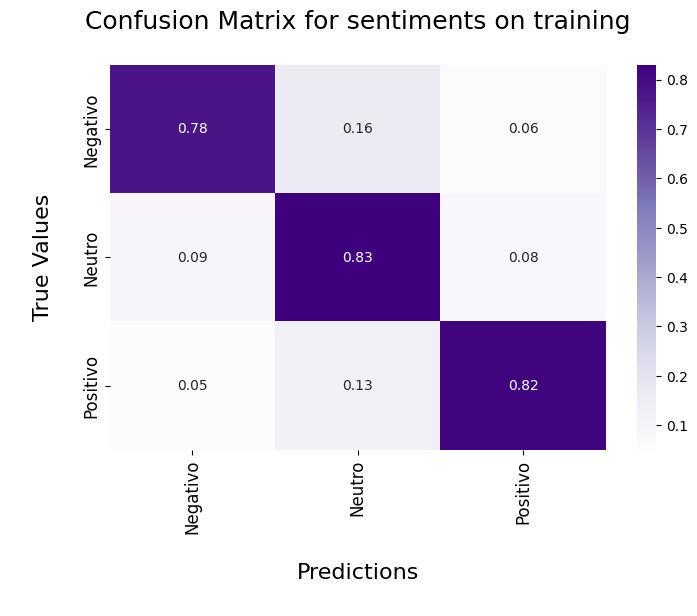

In [36]:
fcm = confusion_matrix(aux.y_train_true.tolist(), aux.y_train_predicted.tolist())
fcm_normalized = np.round(fcm/np.sum(fcm, axis=1).reshape(-1, 1), 2)

sentiments = np.array(['Negativo', 'Neutro', 'Positivo'], dtype='<U15')

plt.figure(figsize=(8, 5))

sns.heatmap(
    fcm_normalized,
    cmap='Purples',
    annot=True,
    cbar_kws={
        'orientation': 'vertical'
    },
    xticklabels=sentiments,
    yticklabels=sentiments
)

plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.title('Confusion Matrix for sentiments on training\n', fontsize=18)
plt.xlabel('\nPredictions\n', fontsize=16)
plt.ylabel('\nTrue Values\n', fontsize=16)

plt.show()

## Validação

In [37]:
y_test_true = y_test
y_test_predicted = model.predict(X_test)

In [38]:
aux = pd.DataFrame(y_test_true, y_test_predicted).reset_index()
aux.columns = ['y_test_true', 'y_test_predicted']

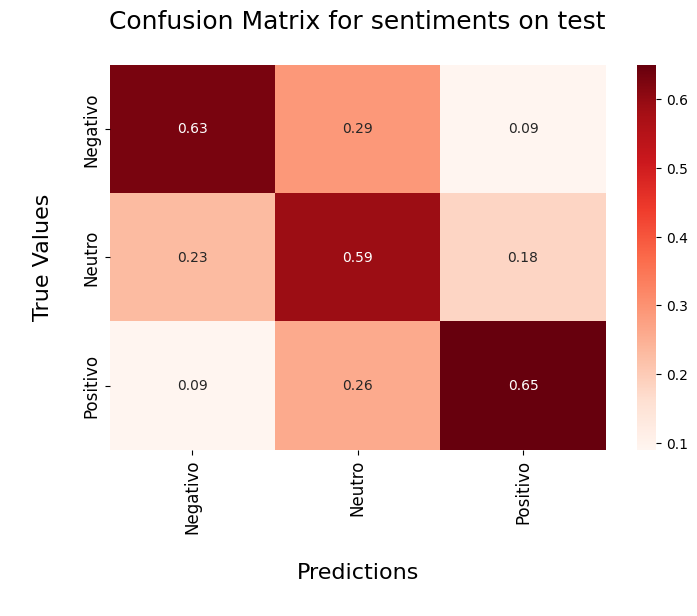

In [39]:
fcm = confusion_matrix(aux.y_test_true.tolist(), aux.y_test_predicted.tolist())
fcm_normalized = np.round(fcm/np.sum(fcm, axis=1).reshape(-1, 1), 2)

sentiments = np.array(['Negativo', 'Neutro', 'Positivo'], dtype='<U15')

plt.figure(figsize=(8, 5))

sns.heatmap(
    fcm_normalized,
    cmap='Reds',
    annot=True,
    cbar_kws={
        'orientation': 'vertical'
    },
    xticklabels=sentiments,
    yticklabels=sentiments
)

plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.title('Confusion Matrix for sentiments on test\n', fontsize=18)
plt.xlabel('\nPredictions\n', fontsize=16)
plt.ylabel('\nTrue Values\n', fontsize=16)

plt.show()

## Delivery

In [75]:
test_df = df.sample(100, random_state=50).reset_index()
test_df['y_pred'] = model.predict(test_df.x_data.tolist())
test_df['label_predicted'] = le.inverse_transform(test_df.y_pred.tolist())
test_df['label_probability'] = [ np.max(i) for i in model.predict_proba(test_df.x_data.tolist())]
test_df.drop(['y_pred'], axis=1, inplace=True)

In [76]:
test_df = test_df[['id', 'timestamp', 'text', 'label_predicted', 'label_probability']]
test_df

,id,timestamp,text,label_predicted,label_probability
0,com.mcdo.mcdonalds,2023-04-17 11:53:38,"os lanches já não são como antigamente, capric...",Neutral,0.633200
1,com.mcdo.mcdonalds,2023-04-13 00:02:54,muitas vezes travando o app,Neutral,0.445293
2,com.vanuatu.aiqfome,2023-04-17 21:06:54,Uma experiência péssima fiz uma compra em um e...,Negative,0.999866
3,com.mcdo.mcdonalds,2023-02-23 21:56:55,top,Positive,0.795477
4,habibs.alphacode.com.br,2022-04-24 22:08:01,"As promoções e layout do app são bons. Porém, ...",Negative,0.714851
...,...,...,...,...,...
95,br.com.brainweb.ifood,2023-02-06 21:22:58,"o app funciona bem, as vezes o rastreamento nã...",Negative,0.962755
96,burgerking.com.br.appandroid,2023-04-11 16:31:23,tá muito caro,Neutral,0.368008
97,burgerking.com.br.appandroid,2022-12-18 22:11:49,Usei uma vez e achei muito bom. Demorei um pou...,Positive,0.874281
98,br.com.brainweb.ifood,2023-04-24 14:27:25,Sinto falta de uma central de atendimento do i...,Positive,0.590025


## Creating the classification function

In [107]:
def classify_review(text: str) -> tuple:
  refined_text = preprocessing(text)[-1]

  vector = vectorizer.transform([refined_text]).toarray().squeeze().tolist()

  pred = model.predict(np.array(vector).reshape(1, -1))
  prediction = le.inverse_transform(pred).item()

  probability = np.max(model.predict_proba(np.array(vector).reshape(1, -1)))

  return prediction, probability

In [108]:
test_1 = 'Eu comprei o aplicativo, gastei bastante mas os preços são muito altos. Com o escândalo que ocorreu mês passado, a empresa deveria abaixar o preço e não subir!!! EU ODIEI A EXPERIÊNCIA'
test_2 = 'Eu adorei o projeto. Eu sei que é algo novo e de teste, mas bem que poderiam criar mais funcionalidades né? 😟 De qualquer forma, não sei bem o que pensar... ainda estou avaliando...'
test_3 = 'Eu AMEI tudoooooOO! ⭐ Eu adorei conhecer o projeto, o único problema é que não é gratuito, mas parabèns 🎉'

In [109]:
print(f'Primeira frase de teste: {test_1}')
print(f'Classificação da primeira frase de teste: {classify_review(test_1)[0]}')
print(f'Probabilidade da primeira classificação: {classify_review(test_1)[-1]}')

Primeira frase de teste: Eu comprei o aplicativo, gastei bastante mas os preços são muito altos. Com o escândalo que ocorreu mês passado, a empresa deveria abaixar o preço e não subir!!! EU ODIEI A EXPERIÊNCIA
Classificação da primeira frase de teste: Neutral
Probabilidade da primeira classificação: 0.7579837323381986


In [110]:
print(f'Segunda frase de teste: {test_2}')
print(f'Classificação da segunda frase de teste: {classify_review(test_2)[0]}')
print(f'Probabilidade da segunda classificação: {classify_review(test_2)[-1]}')

Segunda frase de teste: Eu adorei o projeto. Eu sei que é algo novo e de teste, mas bem que poderiam criar mais funcionalidades né? 😟 De qualquer forma, não sei bem o que pensar... ainda estou avaliando...
Classificação da segunda frase de teste: Positive
Probabilidade da segunda classificação: 0.7459841597400889


In [111]:
print(f'Terceira frase de teste: {test_3}')
print(f'Classificação da terceira frase de teste: {classify_review(test_3)[0]}')
print(f'Probabilidade da terceira classificação: {classify_review(test_3)[-1]}')

Terceira frase de teste: Eu AMEI tudoooooOO! ⭐ Eu adorei conhecer o projeto, o único problema é que não é gratuito, mas parabèns 🎉
Classificação da terceira frase de teste: Positive
Probabilidade da terceira classificação: 0.9991184214690596


<p align='center'> <img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT06tAs2MV7Knw26Kmhv6SXYm1krjvniwjqIWWyuAv7r1V6tqC3hncVtwefz8SbLdz7DlA&usqp=CAU' width=500> </p>